### Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

import os
import json
import time
import pickle
import argparse
from collections import OrderedDict

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Params

In [45]:
parser = argparse.ArgumentParser()
parser.add_argument("--lr", default=0.0005, type=float,
					help="learning rate.")
parser.add_argument("--dropout", default=0.5, type=float,
					help="dropout rate.")
parser.add_argument("--batch_size", default=128, type=int,
					help="batch size when training.")
parser.add_argument("--gpu", default="0", type=str,
					help="gpu card ID.")
parser.add_argument("--epochs", default=20, type=str,
					help="training epoches.")
parser.add_argument("--clip_norm", default=5.0, type=float,
					help="clip norm for preventing gradient exploding.")
parser.add_argument("--embed_size", default=30, type=int, help="embedding size for users and items.")
parser.add_argument("--attention_size", default=50, type=int, help="embedding size for users and items.")
parser.add_argument("--item_layer1_nei_num", default=10, type=int)
parser.add_argument("--user_layer1_nei_num", default=10, type=int)
parser.add_argument("--vae_lambda", default=1, type=int)

_StoreAction(option_strings=['--vae_lambda'], dest='vae_lambda', nargs=None, const=None, default=1, type=<class 'int'>, choices=None, required=False, help=None, metavar=None)

## Dataset

In [5]:
!wget -q --show-progress https://github.com/sparsh-ai/coldstart-recsys/raw/main/data/AGNN/ml100k.zip
!unzip ml100k.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
def get_data_list(ftrain, batch_size):
    f = open(ftrain, 'r')
    train_list = []
    for eachline in f:
        eachline = eachline.strip().split('\t')
        u, i, l = int(eachline[0]), int(eachline[1]), float(eachline[2])
        train_list.append([u, i, l])
    num_batches_per_epoch = int((len(train_list) - 1) / batch_size) + 1
    return num_batches_per_epoch, train_list

In [7]:
def get_batch_instances(train_list, user_feature_dict, item_feature_dict, item_director_dict, item_writer_dict, item_star_dict, item_country_dict, batch_size, user_nei_dict, item_nei_dict, shuffle=True):
    num_batches_per_epoch = int((len(train_list) - 1) / batch_size) + 1
    def data_generator(train_list):
        data_size = len(train_list)
        user_feature_arr = np.array(list(user_feature_dict.values()))
        max_user_cate_size = user_feature_arr.shape[1]

        item_genre_arr = np.array(list(item_feature_dict.values())) #len=6 ,0
        item_director_arr = np.array(list(item_director_dict.values())) #len=3 ,6
        item_writer_arr = np.array(list(item_writer_dict.values())) #len=3, 9
        item_star_arr = np.array(list(item_star_dict.values())) #len=3, 12
        item_country_arr = np.array(list(item_country_dict.values()))   #len=8, 15

        item_feature_arr = np.concatenate([item_genre_arr, item_director_arr, item_writer_arr, item_star_arr, item_country_arr], axis=1)
        max_item_cate_size = item_feature_arr.shape[1]

        item_layer1_nei_num = FLAGS.item_layer1_nei_num
        user_layer1_nei_num = FLAGS.user_layer1_nei_num

        if shuffle == True:
            np.random.shuffle(train_list)
        train_list = np.array(train_list)

        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            current_batch_size = end_index - start_index

            u = train_list[start_index: end_index][:, 0].astype(np.int)
            i = train_list[start_index: end_index][:, 1].astype(np.int)
            l = train_list[start_index: end_index][:, 2]

            i_self_cate = np.zeros([current_batch_size, max_item_cate_size], dtype=np.int)
            i_onehop_id = np.zeros([current_batch_size, item_layer1_nei_num], dtype=np.int)
            i_onehop_cate = np.zeros([current_batch_size, item_layer1_nei_num, max_item_cate_size], dtype=np.int)

            u_self_cate = np.zeros([current_batch_size, max_user_cate_size], dtype=np.int)
            u_onehop_id = np.zeros([current_batch_size, user_layer1_nei_num], dtype=np.int)
            u_onehop_cate = np.zeros([current_batch_size, user_layer1_nei_num, max_user_cate_size], dtype=np.int)

            for index, each_i in enumerate(i):
                i_self_cate[index] = item_feature_arr[each_i]    #item_self_cate

                tmp_one_nei = item_nei_dict[each_i][0]
                tmp_prob = item_nei_dict[each_i][1]
                if len(tmp_one_nei) > item_layer1_nei_num:  #re-sampling
                    tmp_one_nei = np.random.choice(tmp_one_nei, item_layer1_nei_num, replace=False, p=tmp_prob)
                elif len(tmp_one_nei) < item_layer1_nei_num:
                    tmp_one_nei = np.random.choice(tmp_one_nei, item_layer1_nei_num, replace=True, p=tmp_prob)
                tmp_one_nei[-1] = each_i

                i_onehop_id[index] = tmp_one_nei    #item_1_neigh
                i_onehop_cate[index] = item_feature_arr[tmp_one_nei]  #item_1_neigh_cate

            for index, each_u in enumerate(u):
                u_self_cate[index] = user_feature_dict[each_u]  # item_self_cate

                tmp_one_nei = user_nei_dict[each_u][0]
                tmp_prob = user_nei_dict[each_u][1]
                if len(tmp_one_nei) > user_layer1_nei_num:  # re-sampling
                    tmp_one_nei = np.random.choice(tmp_one_nei, user_layer1_nei_num, replace=False, p=tmp_prob)
                elif len(tmp_one_nei) < user_layer1_nei_num:
                    tmp_one_nei = np.random.choice(tmp_one_nei, user_layer1_nei_num, replace=True, p=tmp_prob)
                tmp_one_nei[-1] = each_u

                u_onehop_id[index] = tmp_one_nei  # user_1_neigh
                u_onehop_cate[index] = user_feature_arr[tmp_one_nei]  # user_1_neigh_cate

            yield ([u, i, l, u_self_cate, u_onehop_id, u_onehop_cate, i_self_cate, i_onehop_id, i_onehop_cate])
    return data_generator(train_list)

## Model

In [8]:
class VAE(nn.Module):

    def __init__(self, embed_size):
        super(VAE, self).__init__()

        Z_dim = X_dim = h_dim = embed_size
        self.Z_dim = Z_dim
        self.X_dim= X_dim
        self.h_dim = h_dim
        self.embed_size= embed_size

        def init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
                if m.bias is not None:
                    nn.init.constant(m.bias, 0)

        # =============================== Q(z|X) ======================================
        self.dense_xh = nn.Linear(X_dim, h_dim)
        init_weights(self.dense_xh)

        self.dense_hz_mu = nn.Linear(h_dim, Z_dim)
        init_weights(self.dense_hz_mu)

        self.dense_hz_var = nn.Linear(h_dim, Z_dim)
        init_weights(self.dense_hz_var)

        # =============================== P(X|z) ======================================
        self.dense_zh = nn.Linear(Z_dim, h_dim)
        init_weights(self.dense_zh)

        self.dense_hx = nn.Linear(h_dim, X_dim)
        init_weights(self.dense_hx)

    def Q(self, X):
        h = nn.ReLU()(self.dense_xh(X))
        z_mu = self.dense_hz_mu(h)
        z_var = self.dense_hz_var(h)
        return z_mu, z_var

    def sample_z(self, mu, log_var):
        mb_size = mu.shape[0]
        eps = Variable(torch.randn(mb_size, self.Z_dim)).cuda()
        return mu + torch.exp(log_var / 2) * eps

    def P(self, z):
        h = nn.ReLU()(self.dense_zh(z))
        X = self.dense_hx(h)
        return X

In [9]:
class AGNN(torch.nn.Module):
    def __init__(self, user_size, item_size, gender_size, age_size, occupation_size, genre_size, director_size, writer_size, star_size, country_size, embed_size, attention_size, dropout):
        super(AGNN, self).__init__()
        self.user_size = user_size
        self.item_size = item_size
        self.gender_size = gender_size
        self.age_size = age_size
        self.occupation_size = occupation_size
        self.genre_size = genre_size
        self.director_size = director_size
        self.writer_size = writer_size
        self.star_size = star_size
        self.country_size = country_size
        self.embed_size = embed_size
        self.dropout = dropout
        self.attention_size = attention_size

        def init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
                if m.bias is not None:
                    nn.init.constant(m.bias, 0)

        self.user_embed = torch.nn.Embedding(self.user_size, self.embed_size)
        self.item_embed = torch.nn.Embedding(self.item_size, self.embed_size)
        nn.init.xavier_uniform(self.user_embed.weight)
        nn.init.xavier_uniform(self.item_embed.weight)

        self.user_bias = torch.nn.Embedding(self.user_size, 1)
        self.item_bias = torch.nn.Embedding(self.item_size, 1)
        nn.init.constant(self.user_bias.weight, 0)
        nn.init.constant(self.item_bias.weight, 0)

        self.miu = torch.nn.Parameter(torch.zeros(1), requires_grad=True)

        self.gender_embed = torch.nn.Embedding(self.gender_size, self.embed_size)
        self.gender_embed.weight.data.normal_(0, 0.05)
        self.age_embed = torch.nn.Embedding(self.age_size, self.embed_size)
        self.age_embed.weight.data.normal_(0, 0.05)
        self.occupation_embed = torch.nn.Embedding(self.occupation_size, self.embed_size)
        self.occupation_embed.weight.data.normal_(0, 0.05)

        self.genre_embed = torch.nn.Embedding(self.genre_size, self.embed_size)
        self.genre_embed.weight.data.normal_(0, 0.05)
        self.director_embed = torch.nn.Embedding(self.director_size, self.embed_size)
        self.director_embed.weight.data.normal_(0, 0.05)
        self.writer_embed = torch.nn.Embedding(self.writer_size, self.embed_size)
        self.writer_embed.weight.data.normal_(0, 0.05)
        self.star_embed = torch.nn.Embedding(self.star_size, self.embed_size)
        self.star_embed.weight.data.normal_(0, 0.05)
        self.country_embed = torch.nn.Embedding(self.country_size, self.embed_size)
        self.country_embed.weight.data.normal_(0, 0.05)


        #--------------------------------------------------
        self.dense_item_self_biinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_item_self_siinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_item_onehop_biinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_item_onehop_siinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_user_self_biinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_user_self_siinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_user_onehop_biinter = nn.Linear(self.embed_size, self.embed_size)
        self.dense_user_onehop_siinter = nn.Linear(self.embed_size, self.embed_size)
        init_weights(self.dense_item_self_biinter)
        init_weights(self.dense_item_self_siinter)
        init_weights(self.dense_item_onehop_biinter)
        init_weights(self.dense_item_onehop_siinter)
        init_weights(self.dense_user_self_biinter)
        init_weights(self.dense_user_self_siinter)
        init_weights(self.dense_user_onehop_biinter)
        init_weights(self.dense_user_onehop_siinter)

        self.dense_item_cate_self = nn.Linear(2 * self.embed_size, self.embed_size)
        self.dense_item_cate_hop1 = nn.Linear(2 * self.embed_size, self.embed_size)
        self.dense_user_cate_self = nn.Linear(2 * self.embed_size, self.embed_size)
        self.dense_user_cate_hop1 = nn.Linear(2 * self.embed_size, self.embed_size)
        init_weights(self.dense_item_cate_self)
        init_weights(self.dense_item_cate_hop1)
        init_weights(self.dense_user_cate_self)
        init_weights(self.dense_user_cate_hop1)

        self.dense_item_addgate = nn.Linear(self.embed_size * 2, self.embed_size)
        init_weights(self.dense_item_addgate)
        self.dense_item_erasegate = nn.Linear(self.embed_size * 2, self.embed_size)
        init_weights(self.dense_item_erasegate)
        self.dense_user_addgate = nn.Linear(self.embed_size * 2, self.embed_size)
        init_weights(self.dense_user_addgate)
        self.dense_user_erasegate = nn.Linear(self.embed_size * 2, self.embed_size)

        self.user_vae = VAE(embed_size)
        self.item_vae = VAE(embed_size)

        #----------------------------------------------------
        #concat, mlp
        self.FC_pre = nn.Linear(2 * embed_size, 1)
        init_weights(self.FC_pre)

        """# dot
        self.user_bias = nn.Embedding(self.user_size, 1)
        self.item_bias = nn.Embedding(self.item_size, 1)
        self.user_bias.weight.data.normal_(0, 0.01)
        self.item_bias.weight.data.normal_(0, 0.01)
        self.bias = torch.nn.Parameter(torch.rand(1), requires_grad=True)
        self.bias.data.uniform_(0, 0.1)"""

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.2)

    def feat_interaction(self, feature_embedding, fun_bi, fun_si, dimension):
        summed_features_emb_square = (torch.sum(feature_embedding, dim=dimension)).pow(2)
        squared_sum_features_emb = torch.sum(feature_embedding.pow(2), dim=dimension)
        deep_fm = 0.5 * (summed_features_emb_square - squared_sum_features_emb)
        deep_fm = self.leakyrelu(fun_bi(deep_fm))
        bias_fm = self.leakyrelu(fun_si(feature_embedding.sum(dim=dimension)))
        nfm = deep_fm + bias_fm
        return nfm

    def forward(self, user, item, user_self_cate, user_onehop_id, user_onehop_cate, item_self_cate, item_self_director, item_self_writer, item_self_star, item_self_country, item_onehop_id, item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star, item_onehop_country, mode='train'):

        uids_list = user.cuda()
        sids_list = item.cuda()
        if mode == 'train' or mode == 'warm':
            user_embedding = self.user_embed(torch.autograd.Variable(uids_list))
            item_embedding = self.item_embed(torch.autograd.Variable(sids_list))
        if mode == 'ics':
            user_embedding = self.user_embed(torch.autograd.Variable(uids_list))
        if mode == 'ucs':
            item_embedding = self.item_embed(torch.autograd.Variable(sids_list))

        batch_size = item_self_cate.shape[0]
        cate_size = item_self_cate.shape[1]
        director_size = item_self_director.shape[1]
        writer_size = item_self_writer.shape[1]
        star_size = item_self_star.shape[1]
        country_size = item_self_country.shape[1]
        user_onehop_size = user_onehop_id.shape[1]
        item_onehop_size = item_onehop_id.shape[1]

        #------------------------------------------------------GCN-item
        # K=2
        item_onehop_id = self.item_embed(Variable(item_onehop_id))

        item_onehop_cate = self.genre_embed(Variable(item_onehop_cate).view(-1, cate_size)).view(batch_size,item_onehop_size,cate_size, -1)
        item_onehop_director = self.director_embed(Variable(item_onehop_director).view(-1, director_size)).view(batch_size, item_onehop_size, director_size, -1)
        item_onehop_writer = self.writer_embed(Variable(item_onehop_writer).view(-1, writer_size)).view(batch_size, item_onehop_size, writer_size, -1)
        item_onehop_star = self.star_embed(Variable(item_onehop_star).view(-1, star_size)).view(batch_size, item_onehop_size, star_size, -1)
        item_onehop_country = self.country_embed(Variable(item_onehop_country).view(-1, country_size)).view(batch_size, item_onehop_size, country_size, -1)

        item_onehop_feature = torch.cat([item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star, item_onehop_country], dim=2)
        item_onehop_embed = self.dense_item_cate_hop1(torch.cat([self.feat_interaction(item_onehop_feature, self.dense_item_onehop_biinter,  self.dense_item_onehop_siinter, dimension=2), item_onehop_id], dim=-1))

        # K=1
        item_self_cate = self.genre_embed(Variable(item_self_cate))
        item_self_director = self.director_embed(Variable(item_self_director))
        item_self_writer = self.writer_embed(Variable(item_self_writer))
        item_self_star = self.star_embed(Variable(item_self_star))
        item_self_country = self.country_embed(Variable(item_self_country))

        item_self_feature = torch.cat([item_self_cate, item_self_director, item_self_writer, item_self_star, item_self_country], dim=1)
        item_self_feature = self.feat_interaction(item_self_feature, self.dense_item_self_biinter, self.dense_item_self_siinter, dimension=1)

        if mode == 'ics':
            item_mu, item_var = self.item_vae.Q(item_self_feature)
            item_z = self.item_vae.sample_z(item_mu, item_var)
            item_embedding = self.item_vae.P(item_z)
        item_self_embed = self.dense_item_cate_self(torch.cat([item_self_feature, item_embedding], dim=-1))

        item_addgate = self.sigmoid(self.dense_item_addgate(torch.cat([item_self_embed.unsqueeze(1).repeat(1, item_onehop_size, 1), item_onehop_embed], dim=-1)))  # 商品的邻居门，控制邻居信息多少作为输入
        item_erasegate = self.sigmoid(self.dense_item_erasegate(torch.cat([item_self_embed, item_onehop_embed.mean(dim=1)], dim=-1)))
        item_onehop_embed_final = (item_onehop_embed * item_addgate).mean(1)
        item_self_embed = (1 - item_erasegate) * item_self_embed

        item_gcn_embed = self.leakyrelu(item_self_embed + item_onehop_embed_final)  # [batch, embed]

        #----------------------------------------------------------GCN-user
        # K=2
        user_onehop_id = self.user_embed(Variable(user_onehop_id))

        user_onehop_gender_emb = self.gender_embed(Variable(user_onehop_cate[:, :, 0]))
        user_onehop_age_emb = self.age_embed(Variable(user_onehop_cate[:, :, 1]))
        user_onehop_occupation_emb = self.occupation_embed(Variable(user_onehop_cate[:, :, 2]))

        user_onehop_feat = torch.cat([user_onehop_gender_emb.unsqueeze(2), user_onehop_age_emb.unsqueeze(2), user_onehop_occupation_emb.unsqueeze(2)], dim=2)
        user_onehop_embed = self.dense_user_cate_hop1(torch.cat([self.feat_interaction(user_onehop_feat, self.dense_user_onehop_biinter, self.dense_user_onehop_siinter, dimension=2), user_onehop_id], dim=-1))

        # K=1
        user_gender_emb = self.gender_embed(Variable(user_self_cate[:, 0]))
        user_age_emb = self.age_embed(Variable(user_self_cate[:, 1]))
        user_occupation_emb = self.occupation_embed(Variable(user_self_cate[:, 2]))

        user_self_feature = torch.cat([user_gender_emb.unsqueeze(1), user_age_emb.unsqueeze(1), user_occupation_emb.unsqueeze(1)], dim=1)
        user_self_feature = self.feat_interaction(user_self_feature, self.dense_user_self_biinter,  self.dense_user_onehop_siinter, dimension=1)

        if mode == 'ucs':
            user_mu, user_var = self.user_vae.Q(user_self_feature)
            user_z = self.user_vae.sample_z(user_mu, user_var)
            user_embedding = self.user_vae.P(user_z)
        user_self_embed = self.dense_user_cate_self(torch.cat([user_self_feature, user_embedding], dim=-1))

        user_addgate = self.sigmoid(self.dense_user_addgate(torch.cat([user_self_embed.unsqueeze(1).repeat(1, user_onehop_size, 1), user_onehop_embed],dim=-1)))
        user_erasegate = self.sigmoid(self.dense_user_erasegate(torch.cat([user_self_embed, user_onehop_embed.mean(dim=1)], dim=-1)))
        user_onehop_embed_final = (user_onehop_embed * user_addgate).mean(dim=1)
        user_self_embed = (1 - user_erasegate) * user_self_embed

        user_gcn_embed = self.leakyrelu(user_self_embed + user_onehop_embed_final)

        #--------------------------------------------------norm
        item_mu, item_var = self.item_vae.Q(item_self_feature)
        item_z = self.item_vae.sample_z(item_mu, item_var)
        item_preference_sample = self.item_vae.P(item_z)

        user_mu, user_var = self.user_vae.Q(user_self_feature)
        user_z = self.user_vae.sample_z(user_mu, user_var)
        user_preference_sample = self.user_vae.P(user_z)

        recon_loss = torch.norm(item_preference_sample - item_embedding) + torch.norm(user_preference_sample - user_embedding)
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(item_z) + item_mu ** 2 - 1. - item_var, 1)) + \
                  torch.mean(0.5 * torch.sum(torch.exp(user_z) + user_mu ** 2 - 1. - user_var, 1))

        ####################################prediction#####################################################

        #concat -> mlp
        bu = self.user_bias(Variable(uids_list))
        bi = self.item_bias(Variable(sids_list))
        #pred = (user_gcn_embed * item_gcn_embed).sum(1, keepdim=True) + bu + bi + (self.miu).repeat(batch_size, 1)
        tmp = torch.cat([user_gcn_embed, item_gcn_embed], dim=1)
        pred = self.FC_pre(tmp) + (user_gcn_embed * item_gcn_embed).sum(1, keepdim=True) + bu + bi + (self.miu).repeat(batch_size, 1)

        return pred.squeeze(), recon_loss, kl_loss

## Metrics and Evaluation

In [75]:
def metrics(model, test_dataloader):
    label_lst, pred_lst = [], []
    rmse, mse, mae = 0,0,0
    count = 0
    val_count=0
    for batch_data in test_dataloader:
        user = torch.LongTensor(batch_data[0]).cuda()
        item = torch.LongTensor(batch_data[1]).cuda()
        label = torch.FloatTensor(batch_data[2]).cuda()
        user_self_cate = torch.LongTensor(batch_data[3]).cuda()
        user_onehop_id = torch.LongTensor(batch_data[4]).cuda()
        user_onehop_cate = torch.LongTensor(batch_data[5]).cuda()
        item_self_cate, item_self_director, item_self_writer, item_self_star, item_self_country = torch.LongTensor(
            batch_data[6])[:, 0:6].cuda(), torch.LongTensor(batch_data[6])[:, 6:9].cuda(), torch.LongTensor(
            batch_data[6])[:, 9:12].cuda(), torch.LongTensor(batch_data[6])[:, 12:15].cuda(), torch.LongTensor(
            batch_data[6])[:, 15:].cuda()
        item_onehop_id = torch.LongTensor(batch_data[7]).cuda()
        item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star, item_onehop_country = torch.LongTensor(
            batch_data[8])[:, :, 0:6].cuda(), torch.LongTensor(batch_data[8])[:, :, 6:9].cuda(), torch.LongTensor(
            batch_data[8])[:, :, 9:12].cuda(), torch.LongTensor(batch_data[8])[:, :, 12:15].cuda(), torch.LongTensor(
            batch_data[8])[:, :, 15:].cuda()
        
        prediction, recon_loss, kl_loss = model(user, item, user_self_cate, user_onehop_id, user_onehop_cate, item_self_cate,
                           item_self_director, item_self_writer, item_self_star, item_self_country, item_onehop_id,
                           item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star,
                           item_onehop_country, mode = mode)
        prediction = prediction.cpu().data.numpy()
        prediction = prediction.reshape(prediction.shape[0])  
        label = label.cpu().numpy()
        # if val_count ==0:
        #     # print(user)
        #     # print(item)
        #     # print(user_self_cate)
        #     print(prediction)
        #     print(label)
        # val_count+=1
        my_rmse = np.sum((prediction - label) ** 2)
        my_mse = np.sum((prediction - label) ** 2)
        my_mae = np.sum(np.abs(prediction - label))
        # my_rmse = torch.sqrt(torch.sum((prediction - label) ** 2) / FLAGS.batch_size)
        rmse+=my_rmse
        mse+=my_mse
        mae+=my_mae
        count += len(user)
        label_lst.extend(list([float(l) for l in label]))
        pred_lst.extend(list([float(l) for l in prediction]))
        # Print user ID, actual label, and predicted label for each user
        user_ids_to_print = [20, 942]
        count_mov=0
        for i in range(len(user)):
            if user[i] in user_ids_to_print and count_mov <10:
                print(f"User ID: {user[i]}, Actual Label: {label[i]}, Predicted Label: {prediction[i]}")
                count_mov+=1



    my_mse = mse/count
    my_rmse = np.sqrt(rmse/count)
    my_mae = mae/count
    return my_rmse, my_mse, my_mae, label_lst, pred_lst


Parameters:
{'lr': 0.0005, 'dropout': 0.5, 'batch_size': 128, 'gpu': '0', 'epochs': 20, 'clip_norm': 5.0, 'embed_size': 30, 'attention_size': 50, 'item_layer1_nei_num': 10, 'user_layer1_nei_num': 10, 'vae_lambda': 1}
user_num 944, item_num 1683, gender_num 2, age_num 7, occupation_num 21, genre_num 19, director_num 1112, writer_num 2016, star_num 2568, country_num 128, mode ics 
##################################################
epoch:  0       tensor(0.6875, device='cuda:0')
##################################################
epoch:  1       tensor(0.5106, device='cuda:0')
##################################################
epoch:  2       tensor(0.6315, device='cuda:0')
##################################################
epoch:  3       tensor(0.6480, device='cuda:0')
##################################################
epoch:  4       tensor(0.5296, device='cuda:0')
##################################################
epoch:  5       tensor(0.4895, device='cuda:0')
#######################

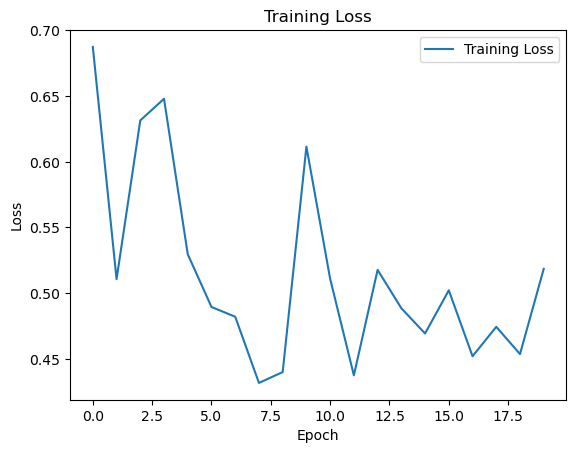

In [58]:
if __name__ == '__main__':
    #item cold start
    folder_info='D:/job data/my work/on going projects/staffordshire university/003_hammad/thesis work/updated Thesis_after_mid/code/data/ml100k/'
    f_info = folder_info+ 'ml100k/uiinfo.pkl'
    f_neighbor = folder_info+ 'ml100k/neighbor_aspect_extension_2_zscore_ics_uuii_0.20.pkl'
    f_train = folder_info+ 'ml100k/ics_train.dat'
    f_test = folder_info+ 'ml100k/ics_val.dat'
    f_model = folder_info+ 'ml100k/agnn_ics_'
    mode = 'ics'

    """# user cold start
    f_info = folder_info+ 'ml100k/uiinfo.pkl'
    f_neighbor = folder_info+ 'ml100k/neighbor_aspect_extension_2_zscore_ucs_uuii.pkl'
    f_train = folder_info+ 'ml100k/ucs_train.dat'
    f_test = folder_info+ 'ml100k/ucs_val.dat'
    f_model = folder_info+  'ml100k/agnn_ucs_'
    mode = 'ucs'"""

    """# warm start
    f_info = folder_info+ 'ml100k/uiinfo.pkl'
    f_neighbor = folder_info+ 'ml100k/neighbor_aspect_extension_2_zscore_warm_uuii.pkl'
    f_train = folder_info+ 'ml100k/warm_train.dat'
    f_test = folder_info+ 'ml100k/warm_val.dat'
    f_model = folder_info+ 'ml100k/agnn_warm_'
    mode = 'warm'"""


    FLAGS = parser.parse_args(args={})
    print("\nParameters:")
    print(FLAGS.__dict__)

    with open(f_neighbor, 'rb') as f:
        neighbor_dict = pickle.load(f)
    user_nei_dict = neighbor_dict['user_nei_dict']
    item_nei_dict = neighbor_dict['item_nei_dict']
    director_num = neighbor_dict['director_num']
    writer_num = neighbor_dict['writer_num']
    star_num = neighbor_dict['star_num']
    country_num = neighbor_dict['country_num']

    item_director_dict = neighbor_dict['item_director_dict']    #dict[i]=[x,x,x]
    item_writer_dict = neighbor_dict['item_writer_dict']        #dict[i]=[x,x,x]
    item_star_dict = neighbor_dict['item_star_dict']            #dict[i]=[x,x,x]
    item_country_dict = neighbor_dict['item_country_dict']      #dict[i]=[x,x,x,x,x,x,x,x]

    with open(f_info, 'rb') as f:
        item_info = pickle.load(f)
    user_num = item_info['user_num']
    item_num = item_info['item_num']
    gender_num = item_info['gender_num']
    age_num = item_info['age_num']
    occupation_num = item_info['occupation_num']
    genre_num = item_info['genre_num']
    user_feature_dict = item_info['user_feature_dict']  #gender, age, occupation    dict[u]=[x,x,x]
    item_feature_dict = item_info['item_feature_dict']  #genre                      dict[i]=[x,x,x,x,x,x]

    print("user_num {}, item_num {}, gender_num {}, age_num {}, occupation_num {}, genre_num {}, director_num {}, writer_num {}, star_num {}, country_num {}, mode {} ".format(user_num, item_num, gender_num, age_num, occupation_num, genre_num, director_num, writer_num, star_num, country_num, mode))

    train_steps, train_list = get_data_list(f_train, batch_size=FLAGS.batch_size)
    test_steps, test_list = get_data_list(f_test, batch_size=FLAGS.batch_size)

    model = AGNN(user_num, item_num, gender_num, age_num, occupation_num, genre_num, director_num, writer_num, star_num, country_num, FLAGS.embed_size, FLAGS.attention_size, FLAGS.dropout)
    model.cuda()

    loss_function = torch.nn.MSELoss(size_average=False)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=FLAGS.lr, weight_decay=0.001)

    writer = SummaryWriter()  # For visualization
    #f_loss_curve = open('tmp_loss_curve.txt', 'w')
    best_rmse = 5

    count = 0
    epochs = []
    loss_values = []
    for epoch in range(FLAGS.epochs):
        #tmp_main_loss, tmp_vae_loss = [], []
        model.train()  # Enable dropout (if have).
        start_time = time.time()
        train_dataloader = get_batch_instances(train_list, user_feature_dict, item_feature_dict, item_director_dict, item_writer_dict, item_star_dict, item_country_dict,  batch_size=FLAGS.batch_size, user_nei_dict=user_nei_dict, item_nei_dict=item_nei_dict, shuffle=True)
        np.int = np.int32
        for idx, batch_data in enumerate(train_dataloader): #u, i, l, u_self_cate, u_onehop_id, u_onehop_rating, u_onehop_cate, i_self_cate, i_onehop_id, i_onehop_cate
            user = torch.LongTensor(batch_data[0]).cuda()
            item = torch.LongTensor(batch_data[1]).cuda()
            label = torch.FloatTensor(batch_data[2]).cuda()
            user_self_cate = torch.LongTensor(batch_data[3]).cuda()
            user_onehop_id = torch.LongTensor(batch_data[4]).cuda()
            user_onehop_cate = torch.LongTensor(batch_data[5]).cuda()
            item_self_cate, item_self_director, item_self_writer, item_self_star, item_self_country = torch.LongTensor(batch_data[6])[:, 0:6].cuda(), torch.LongTensor(batch_data[6])[:, 6:9].cuda(), torch.LongTensor(batch_data[6])[:, 9:12].cuda(), torch.LongTensor(batch_data[6])[:, 12:15].cuda(), torch.LongTensor(batch_data[6])[:, 15:].cuda()
            item_onehop_id = torch.LongTensor(batch_data[7]).cuda()
            item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star, item_onehop_country = torch.LongTensor(batch_data[8])[:, :, 0:6].cuda(), torch.LongTensor(batch_data[8])[:, :, 6:9].cuda(), torch.LongTensor(batch_data[8])[:, :, 9:12].cuda(), torch.LongTensor(batch_data[8])[:, :, 12:15].cuda(), torch.LongTensor(batch_data[8])[:, :, 15:].cuda()

            model.zero_grad()
            prediction, recon_loss, kl_loss = model(user, item, user_self_cate, user_onehop_id, user_onehop_cate, item_self_cate, item_self_director, item_self_writer, item_self_star, item_self_country, item_onehop_id, item_onehop_cate, item_onehop_director, item_onehop_writer, item_onehop_star, item_onehop_country, mode='train')

            label = Variable(label)

            main_loss = loss_function(prediction, label)
            loss = main_loss + FLAGS.vae_lambda * (recon_loss + kl_loss)

            loss.backward()
            # nn.utils.clip_grad_norm(model.parameters(), FLAGS.clip_norm)
            optimizer.step()
            writer.add_scalar('data/loss', loss.data, count)
            count += 1

        tmploss = torch.sqrt(loss / FLAGS.batch_size)
        print(50 * '#')
        print('epoch: ', epoch, '     ', tmploss.detach())
        epochs.append(epoch)
        loss=  tmploss.item()
        loss_values.append(loss)
    

        # model.eval()
        # print('time = ', time.time() - start_time)
        # test_dataloader = get_batch_instances(test_list, user_feature_dict, item_feature_dict, item_director_dict, item_writer_dict, item_star_dict, item_country_dict, batch_size=FLAGS.batch_size, user_nei_dict=user_nei_dict, item_nei_dict=item_nei_dict, shuffle=False)
        # rmse, mse, mae, label_lst, pred_lst = metrics(model, test_dataloader)
        # print('test rmse,mse,mae: ', rmse,mse,mae)

        """if (rmse < best_rmse):
            best_rmse = rmse
            f_name = f_model + str(best_rmse)[:7] + '.dat' #f_model + str(best_rmse)[:7] + '.dat'
            #torch.save(model, f_name)
            f = open(f_name, 'w')
            res_dict = {}
            res_dict['label'] = label_lst
            res_dict['pred'] = pred_lst
            json.dump(res_dict, f)
            f.close()
            print('save result ok')"""
            
    import matplotlib.pyplot as plt
    # Plot loss values
    plt.plot(epochs, loss_values, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [76]:
model.eval()
print('time = ', time.time() - start_time)
test_dataloader = get_batch_instances(test_list, user_feature_dict, item_feature_dict, item_director_dict, item_writer_dict, item_star_dict, item_country_dict, batch_size=FLAGS.batch_size, user_nei_dict=user_nei_dict, item_nei_dict=item_nei_dict, shuffle=False)
rmse, mse, mae, label_lst, pred_lst = metrics(model, test_dataloader)
print('test rmse,mse,mae: ', rmse,mse,mae)

time =  1619.3224289417267
User ID: 20, Actual Label: 2.0, Predicted Label: 2.8171303272247314
User ID: 20, Actual Label: 4.0, Predicted Label: 2.776099443435669
User ID: 20, Actual Label: 3.0, Predicted Label: 2.7290782928466797
User ID: 20, Actual Label: 3.0, Predicted Label: 2.333571195602417
User ID: 20, Actual Label: 4.0, Predicted Label: 3.0525705814361572
User ID: 20, Actual Label: 1.0, Predicted Label: 2.9623756408691406
User ID: 20, Actual Label: 4.0, Predicted Label: 2.895270824432373
User ID: 20, Actual Label: 1.0, Predicted Label: 2.9254229068756104
User ID: 20, Actual Label: 5.0, Predicted Label: 3.226651191711426
User ID: 942, Actual Label: 4.0, Predicted Label: 4.353408336639404
User ID: 942, Actual Label: 4.0, Predicted Label: 4.347207069396973
User ID: 942, Actual Label: 4.0, Predicted Label: 3.3969931602478027
User ID: 942, Actual Label: 4.0, Predicted Label: 4.005530834197998
User ID: 942, Actual Label: 3.0, Predicted Label: 3.671272039413452
User ID: 942, Actual Lab

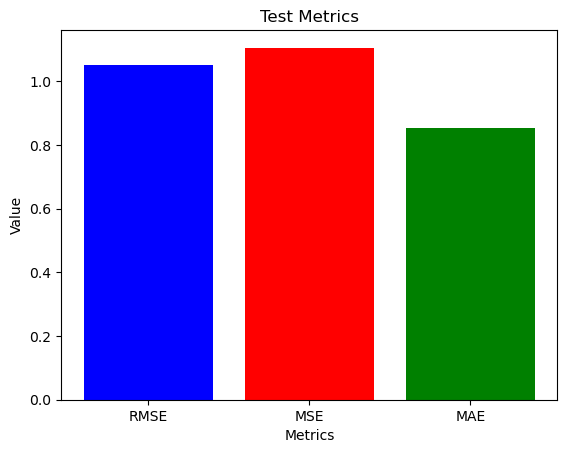

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming rmse, mse, and mae are the test values obtained from evaluation
test_metrics = ['RMSE', 'MSE', 'MAE']
values = [rmse, mse, mae]

# Plotting the bar graph
plt.bar(test_metrics, values, color=['blue', 'red', 'green'])

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Test Metrics')

# Displaying the plot
plt.show()


<generator object get_batch_instances.<locals>.data_generator at 0x0000024AE6B0AED0>

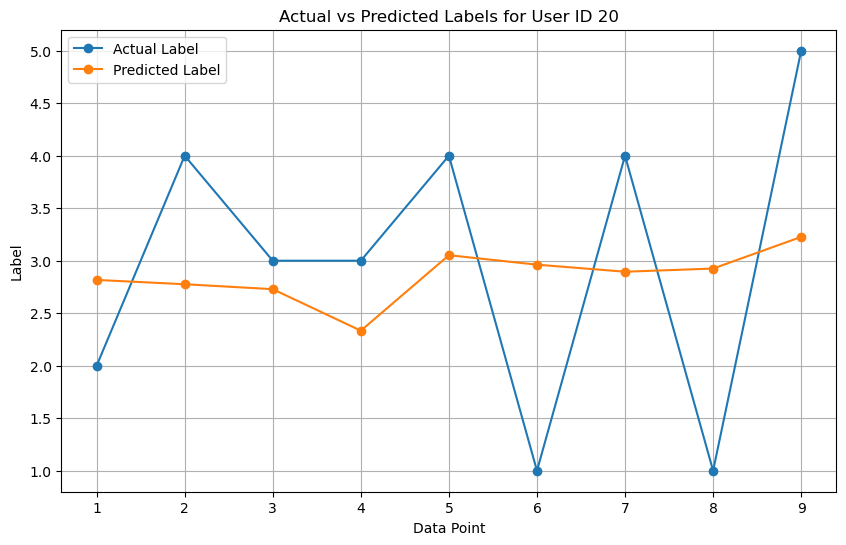

In [79]:
import matplotlib.pyplot as plt

# Actual and predicted labels for User ID 20
actual_labels = [2.0, 4.0, 3.0, 3.0, 4.0, 1.0, 4.0, 1.0, 5.0]
predicted_labels = [2.8171303272247314, 2.776099443435669, 2.7290782928466797, 2.333571195602417,
                    3.0525705814361572, 2.9623756408691406, 2.895270824432373, 2.9254229068756104, 3.226651191711426]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(actual_labels) + 1), actual_labels, marker='o', label='Actual Label')
plt.plot(range(1, len(predicted_labels) + 1), predicted_labels, marker='o', label='Predicted Label')
plt.xlabel('Data Point')
plt.ylabel('Label')
plt.title('Actual vs Predicted Labels for User ID 20')
plt.legend()
plt.grid(True)
plt.show()




In [81]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Actual labels and predicted labels
actual_labels = [2.0, 4.0, 3.0, 3.0, 4.0, 1.0, 4.0, 1.0, 5.0]
predicted_labels = [2.817, 2.776, 2.729, 2.334, 3.053, 2.962, 2.895, 2.925, 3.227]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_labels, predicted_labels))
print("RMSE:", rmse)

# Calculate MSE
mse = mean_squared_error(actual_labels, predicted_labels)
print("MSE:", mse)

# Calculate MAE
mae = mean_absolute_error(actual_labels, predicted_labels)
print("MAE:", mae)


RMSE: 1.312296291069801
MSE: 1.7221215555555558
MAE: 1.1877777777777778


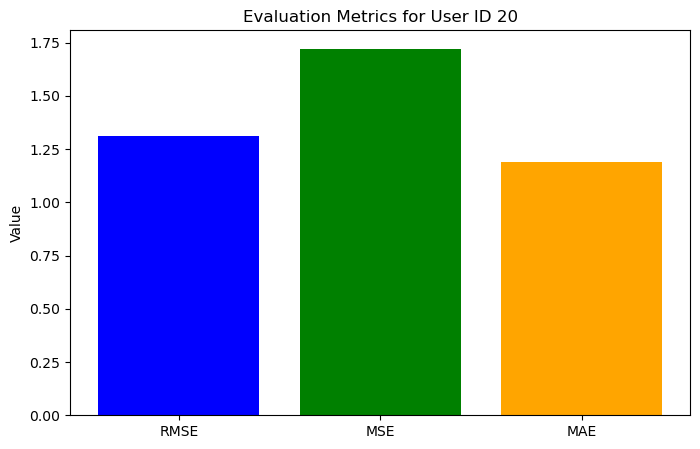

In [86]:
import matplotlib.pyplot as plt

# Actual and predicted labels
actual_labels = [2.0, 4.0, 3.0, 3.0, 4.0, 1.0, 4.0, 1.0, 5.0]
predicted_labels = [2.817, 2.776, 2.729, 2.334, 3.053, 2.962, 2.895, 2.925, 3.227]

# Calculate errors
rmse = np.sqrt(mean_squared_error(actual_labels, predicted_labels))
mse = mean_squared_error(actual_labels, predicted_labels)
mae = mean_absolute_error(actual_labels, predicted_labels)

# Create bar plot
labels = ['RMSE', 'MSE', 'MAE']
values = [rmse, mse, mae]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'green', 'orange'])
plt.title('Evaluation Metrics for User ID 20')
plt.ylabel('Value')
plt.show()


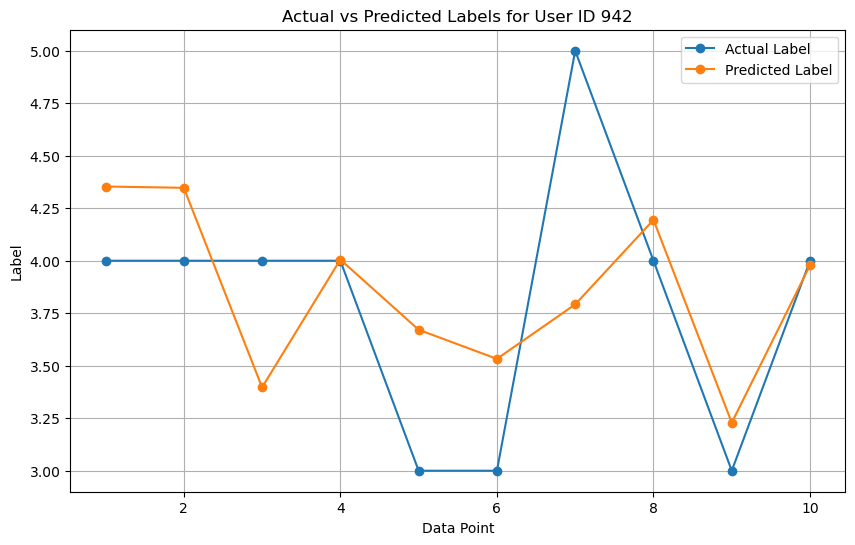

In [80]:
import matplotlib.pyplot as plt

# Actual and predicted labels for User ID 942
actual_labels = [4.0, 4.0, 4.0, 4.0, 3.0, 3.0, 5.0, 4.0, 3.0, 4.0]
predicted_labels = [4.353408336639404, 4.347207069396973, 3.3969931602478027, 4.005530834197998,
                    3.671272039413452, 3.532707691192627, 3.7920644283294678, 4.194568157196045,
                    3.2287747859954834, 3.978933095932007]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(actual_labels) + 1), actual_labels, marker='o', label='Actual Label')
plt.plot(range(1, len(predicted_labels) + 1), predicted_labels, marker='o', label='Predicted Label')
plt.xlabel('Data Point')
plt.ylabel('Label')
plt.title('Actual vs Predicted Labels for User ID 942')
plt.legend()
plt.grid(True)
plt.show()


RMSE: 0.5378813995668562
MSE: 0.28931640000000003
MAE: 0.41660000000000014


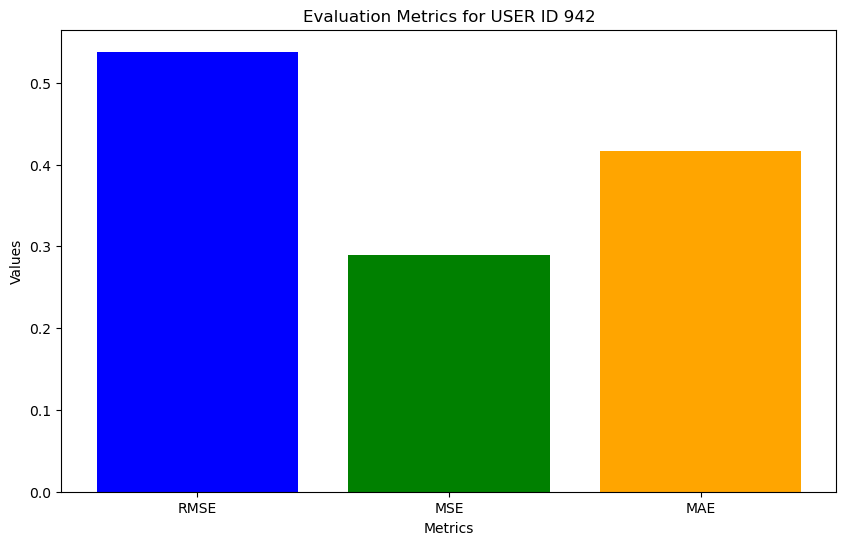

In [88]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Actual labels and predicted labels
actual_labels = [4.0, 4.0, 4.0, 4.0, 3.0, 3.0, 5.0, 4.0, 3.0, 4.0]
predicted_labels = [4.353, 4.347, 3.397, 4.006, 3.671, 3.533, 3.792, 4.195, 3.229, 3.979]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_labels, predicted_labels))
print("RMSE:", rmse)

# Calculate MSE
mse = mean_squared_error(actual_labels, predicted_labels)
print("MSE:", mse)

# Calculate MAE
mae = mean_absolute_error(actual_labels, predicted_labels)
print("MAE:", mae)

# Visualize the RMSE, MSE, and MAE
labels = ['RMSE', 'MSE', 'MAE']
values = [rmse, mse, mae]

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'green', 'orange'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Evaluation Metrics for USER ID 942')
plt.show()


**END**